In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\siyue\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\siyue\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Index
##Load and Inspect Data
###Handle Age Outliers
###Exploratory Data Analysis
####Inspect Country's distribution and its relationship with conversion
####Inspect User type's distribution and its relationship with conversion
####Inspect source's distribution and its relationship with conversion
####Inspect age's distribution and its relationship with conversion
####Inspect total page visits' distribution and its relationship with conversion
##Data Preprocessing
##Classify by using Logistic Regression

##Load and Inspect Data

In [4]:
data = pd.read_csv('C:/Users/siyue/OneDrive/Desktop/Machine Learning/Take-home challenges/Data/conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [6]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [15]:
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:22s} {1:9d}\t'.format(column, len(uniques)), uniques[:5])

country                        4	 ['China', 'Germany', 'UK', 'US']
age                           60	 [17, 18, 19, 20, 21]
new_user                       2	 [0, 1]
source                         3	 ['Ads', 'Direct', 'Seo']
total_pages_visited           29	 [1, 2, 3, 4, 5]
converted                      2	 [0, 1]


In [16]:
data[data['age'] > 100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


There are only two records that is invalid, so let's remove them directly.

In [17]:
data = data[data['age'] < 100]

###Exploratory Data Analysis
####Inspect Country's distribution and its relationship with conversion

In [22]:
#Visualization of different countries
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()
grouped

,country,converted
0,China,0.001332
1,Germany,0.062428
2,UK,0.052612
3,US,0.037801


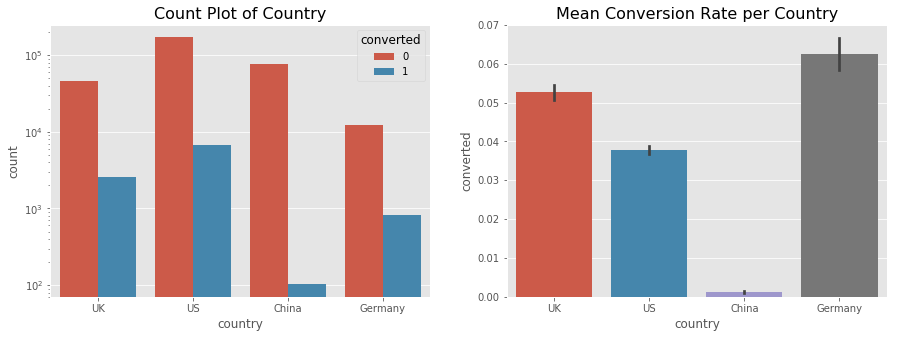

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout
plt.show()

From above plots, at least we can see two problems:
    1. There are many users from China, but the conversion rate is the lowest.
    2. Conversion rate in German is very high, but there are not many users from German.

In [26]:
#Visualization of old users and new users
grouped = data[['new_user', 'converted']].groupby('new_user').mean().reset_index()
grouped

,new_user,converted
0,0,0.071983
1,1,0.014021


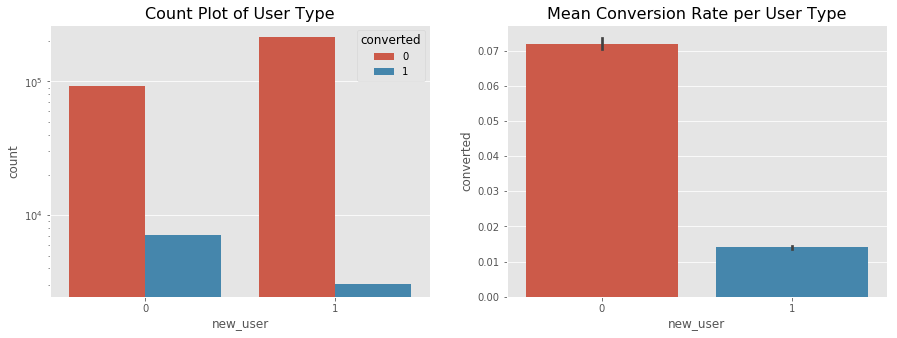

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of User Type', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout
plt.show()

From plots above, we can see old users have better conversion rate.

In [32]:
#Visualization of different sources
grouped = data[['source', 'converted']].groupby('source').mean().reset_index()
grouped

,source,converted
0,Ads,0.034472
1,Direct,0.028169
2,Seo,0.032888


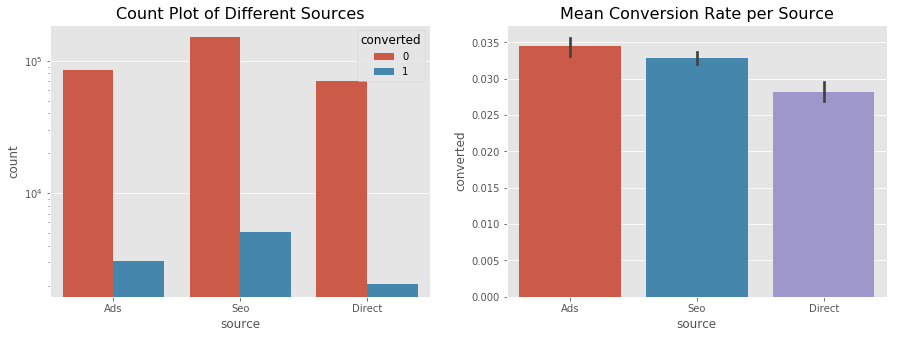

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout
plt.show()

Ads have the highest conversion rate.

In [47]:
#Visualization of age
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
grouped.head()
hist_kws = {'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

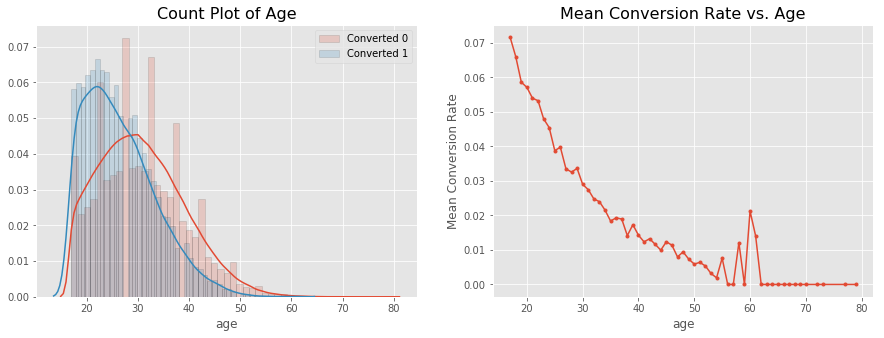

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean Conversion Rate')
ax[1].grid(True)
plt.show()

From plots above, we can see:
    1. People who are older than 60 have a conversion rate of 0.
    2. Age is a negative factor, the older the user is, the less likely he/she will convert.

In [51]:
#Visualization of total pages visited
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()
grouped.head()
hist_kws = {'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

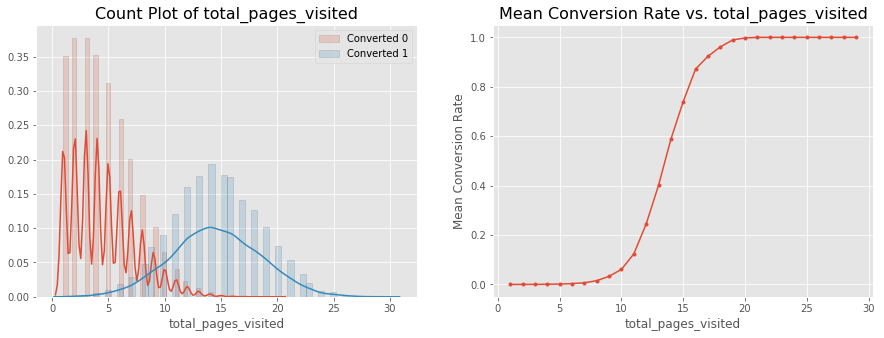

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of total_pages_visited', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean Conversion Rate')
ax[1].grid(True)
plt.show()

##Data Preprocessing

In [54]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


Original dataframe has Categorical features 'country' and 'source', we use One-Hot-Encoding to transform them into numerical values.

In [55]:
X = data.loc[:,('country', 'age', 'new_user', 'source', 'total_pages_visited')]
X = pd.get_dummies(X) # One-Hot-Encoding those categorical features

In [56]:
X.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1


In [57]:
y = data.converted
y.mean()

0.03225194340255157

From the mean value of y, we know that target value is highly imbalanced, which reminds us not to use plain 'accuracy' as the metric to judge a classifier is good or not. Now, split the full dataset into 'training' and 'test'.

In [60]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.333)
ytrain.mean(), ytest.mean()

(0.032114137237795395, 0.03252796930499364)

Since both the mean values of ytrain and ytest are similar, we can conclude the splitting process does not import any bias.

##Classify via Logistic Regression

In [61]:
## since the problem cares giving explanation on each factor
## it seems it would be better to use L1 penalty
## however, L1 penalty doesn't produce a sparse coeffecient, but AUC is much lower
## so I switch back to use L2 penalty
lrModel = LogisticRegressionCV(Cs = np.logspace(-3,3,7),
                            dual=False,
                            scoring='roc_auc',
                            max_iter=1000,
                            n_jobs=-1,
                            verbose=1)
lrModel.fit(Xtrain,ytrain)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.1s finished


LogisticRegressionCV(Cs=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=1000, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=None, refit=True,
           scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=1)

In [62]:
lrModel.C_

array([100.])

In [63]:
lrModel.scores_

{1: array([[0.981417  , 0.98454309, 0.98523827, 0.98526381, 0.98526118,
         0.98526118, 0.98526118],
        [0.98272722, 0.98577242, 0.98647134, 0.98652681, 0.98653086,
         0.98653093, 0.98653093],
        [0.98323844, 0.98631549, 0.98710033, 0.98717476, 0.98717861,
         0.98717861, 0.98717861]])}

In [64]:
lrModel.score(Xtrain,ytrain)

0.9861453552327125

In [67]:
lrModel.score(Xtest,ytest)

0.9862860181966684

In [68]:
1 - ytest.mean()

0.9674720306950063

In [78]:
ytest_predict = lrModel.predict(Xtest)
print(classification_report(y_true=ytest,y_pred=ytest_predict))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    101869
          1       0.86      0.69      0.77      3425

avg / total       0.99      0.99      0.99    105294



from above, we know for "label=converted", if we use the default cutoff 0.5, we can have a high precision (0.85), but a not very good recall 0.68, which means we classify 32% converted user as non-converted.

since our task is giving Sales team and Marking team some insights, so we don't need to tune the cutoff value now, since that won't affect the model. however, if, for example, if we care more about not losing a valued customer, so incorrectly classifing a converted user as non-converted will pay much, we need to lower down the cut-off probability to be 1, which will increase the recall with the price lower than precision.

since this is an imbalanced classification problem, if we group every record as 'NOT converted', we can still get 96.73 accuracy (1-ytest.mean()). since our LR model produces an accurancy as 98.57% on test dataset, which indicates it is a model which makes sense.

In [79]:
feat_importances = pd.DataFrame({"name":Xtrain.columns,"coef":lrModel.coef_[0]})
feat_importances = feat_importances[['name','coef']]# reorder the columns
feat_importances['importances'] = np.abs( feat_importances['coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances

,name,coef,importances
3,country_China,-2.648918,2.648918
1,new_user,-1.750642,1.750642
4,country_Germany,1.099862,1.099862
5,country_UK,0.915296,0.915296
2,total_pages_visited,0.759816,0.759816
6,country_US,0.518327,0.518327
8,source_Direct,-0.186541,0.186541
0,age,-0.071974,0.071974
7,source_Ads,0.065551,0.065551
9,source_Seo,0.005557,0.005557


From descriptive and predictive analysis above, we can draw conclusions below:

1. Conversion among China users are very bad. We know that there are lot of users coming from China, but their conversion rate is very low. Consider China's economic and population, there is a huge opportunity if we target Chinese users and improve their conversion rate. we should consider whether our website has good Chinese translation and satisfy Chinese users' culture requirement.
2. Conversion from Germany is good. We know that there isn't a lot of users from German. so it's a huge opportuntity for us to target German users. for example, put more advertisement in German.
3. Old users have better conversion rate. we should keep touch with them, for example, send promotion email or coupons to old users.
4. Age is a negative factor. the older the user is, the less likely he/she will convert. then we should figure out why young people loves the web pages and strengthen it. and also find out why older people doesn't like our web pages, and try to correct it.
5. Total_pages_visited is a positive factor. the longer the user browse our web page, the more likely he/she will convert and buy something. then if we find some user browse a lot and didn't buy anything, we can send email to remaind them.